# MED-SKIM

A deep learning NLP model that can skim any medical RCT abstract and return a well structured abstract.

ie:, The model seperated each sentence of the abstract and divides them into classes such as OBJECTIVE, BACKGROUND, CONCLUSION etc, based on their actual purpose.

## Get the data

The dataset used for this project is the **PubMed 200K RCT**. PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately **200,000** abstracts of randomized controlled trials, totaling **2.3 million sentences**. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion.

To know more about pubmed visit: https://pubmed.ncbi.nlm.nih.gov/.

The dataset is available at : https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
import os

In [4]:
!nvidia-smi

Tue Apr 16 14:53:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Download the dataset from the github:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [6]:
# Check the downloaded directory:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [7]:
# Check the files in 20K_RCT folder:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


The folder consists of 4 types of dataset.

* PubMed_200k_RCT - This contains 200,000 abstracts of randomized controlled trials
* Pubmed_200k_RCT_numbers_replaced_with_at_sign - The same dataset but all numbers are replaced with @ sign.
* Pubmed_20k_RCT - This contains a smaller version of the main dataset. 20000 samples only
* Pubmed_20k_RCT_numbers_replaced_with_at_sign - The above dataset with numbers replaced with @ sign


For our current project we will be using the **PubMed_20k_RCT_numbers_replaced_with_at_sign** dataset to save time and resourses.

Future scope of this project would be to use the entire dataset.

In [8]:
# Starts with using 20K rct folder:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [9]:
# Create a list of all the text file within the directory:
file_names = [data_dir + name for name in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [10]:
# Create a function for open and read the text file:
def open_and_read(link):
  with open(link,'r') as f:
    return f.readlines()

In [11]:
# Check some examples, hows our data looks like:
train_lines = open_and_read(file_names[2])
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

This is how a single abstract from the dataset looks like :

'###24290286

**BACKGROUND**	IgE sensitization .....

**BACKGROUND**	It is not clear whether these patients would benefit from antifungal treatment .

**OBJECTIVE**	We sought to determine whether a @-month course of voriconazole improved asthma-related ....

**METHODS**	Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months .....

**METHODS**	Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months .....

**RESULTS**	Sixty-five patients were randomized .

**RESULTS**	Fifty-nine patients started treatment ....

**RESULTS**	Fifty-six patients took the full @ months of medication .

RESULTS	Between the voriconazole and placebo groups , there were no significant differences in the number of ....

CONCLUSIONS	We were unable to ....


---

**We have to make the dataset more structured and more python-friendly**

In [12]:
# Create a function which creates a list of dictionary for each sentence:

def process_text_with_line_no(file):
  input_lines = open_and_read(file)
  abstract_line = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_line = ""

    elif line.isspace():
      abstract_list = abstract_line.splitlines()

      for abstract_line_no, abstarct_line in enumerate(abstract_list):
        dictionary = {}
        splitted_abstract_line =  abstarct_line.split("\t")
        dictionary['target'] = splitted_abstract_line[0]
        dictionary['text'] = splitted_abstract_line[1]
        dictionary['line_number'] = abstract_line_no
        dictionary['total_lines'] = len(abstract_list) - 1
        abstract_samples.append(dictionary)

    else:
      abstract_line += line

  return abstract_samples

In [13]:
# Check the lengths of the samples:
test_samples = process_text_with_line_no(file_names[0])
dev_samples = process_text_with_line_no(file_names[1])
train_samples = process_text_with_line_no(file_names[2])
len(test_samples),len(dev_samples),len(train_samples)

(30212, 30135, 180040)

In [14]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [15]:
# Create the Data Frame:
import pandas as pd
test_sample_df = pd.DataFrame(test_samples)
train_sample_df = pd.DataFrame(train_samples)
dev_sample_df = pd.DataFrame(dev_samples)

In [16]:
train_sample_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [17]:
train_sample_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

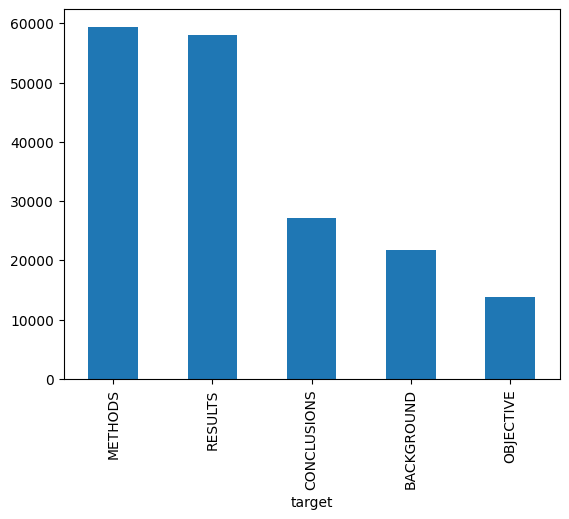

In [18]:
# Plot on the graph:
train_sample_df.target.value_counts().plot.bar();

<Axes: ylabel='Frequency'>

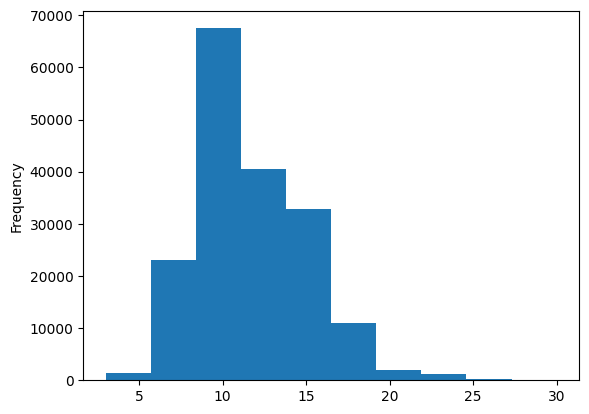

In [19]:
train_sample_df.total_lines.plot.hist()

# Model_0: Multimodial Naive Bayes(Base Line Model)

In [20]:
# Convert the abstract text to the the list:
train_abstract_list = train_sample_df.text.to_list()
test_abstract_list = test_sample_df.text.to_list()
dev_abstract_list = dev_sample_df.text.to_list()

len(train_abstract_list), len(test_abstract_list), len(dev_abstract_list)

(180040, 30212, 30135)

In [21]:
# Convert the target to one hot encoder and the labelEncoder:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_target_one_hot = one_hot_encoder.fit_transform(train_sample_df.target.to_numpy().reshape(-1,1))
test_target_one_hot = one_hot_encoder.transform(test_sample_df.target.to_numpy().reshape(-1,1))
dev_target_one_hot = one_hot_encoder.transform(dev_sample_df.target.to_numpy().reshape(-1,1))


In [22]:
train_target_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [23]:
# Convert the targets to the label encoder:
label_encoder = LabelEncoder()
train_target_label_encode = label_encoder.fit_transform(train_sample_df.target)
test_target_label_encode = label_encoder.transform(test_sample_df.target)
dev_target_label_encode = label_encoder.transform(dev_sample_df.target)

len(train_target_label_encode), len(test_target_label_encode), len(dev_target_label_encode )

(180040, 30212, 30135)

In [24]:
label_encoder.classes_, len(label_encoder.classes_)

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

In [25]:
label_encoder_classes = list(label_encoder.classes_)

In [26]:
# Import the model,vectorizor and the pipeline from the sklearn:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create the ML pipeline:
model_0 = Pipeline([
    ("Vectorizor",TfidfVectorizer()),
    ("Model",MultinomialNB())]
)

# Fit the Model:
model_0.fit(X=train_abstract_list,
            y=train_target_label_encode)

Pipeline(steps=[('Vectorizor', TfidfVectorizer()), ('Model', MultinomialNB())])

In [27]:
# Check the accuracy:
baseline_accuracy = model_0.score(train_abstract_list,train_target_label_encode)
baseline_accuracy

0.7516829593423684

In [28]:
# Make prdictions on validation dataset:
dev_pred = model_0.predict(dev_abstract_list)
dev_pred[:5]

array([2, 2, 2, 4, 4])

In [29]:
# Download the Helper Function script:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-16 14:53:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-16 14:53:49 (57.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [30]:
from helper_functions import calculate_results
baseline_scores = calculate_results(y_true = dev_target_label_encode,
                               y_pred = dev_pred)
baseline_scores

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

# Model_1: Model in Paper without label Encoding



In this project we are going to be making 3 model for comparison. The base architecture used for this project is Multinomial Naive Bayes & Final is based on the research done by Franck Dernoncourt and Ji Young Lee. The paper is available here: https://arxiv.org/pdf/1710.06071.pdf


The final model architecture we are going to keep is found here : https://arxiv.org/pdf/1612.05251.pdf

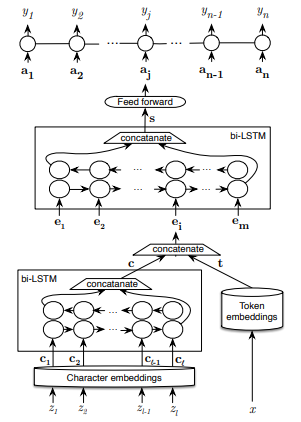

## Preparing the Dataset for Token Level Embeddings:




In [31]:
# Checking the average average length of the sentence in train dataset:
length_sentence_list = [len(sentence.split(" ")) for sentence in train_abstract_list]
averange_length = sum(length_sentence_list) / len(length_sentence_list)
averange_length

26.338269273494777

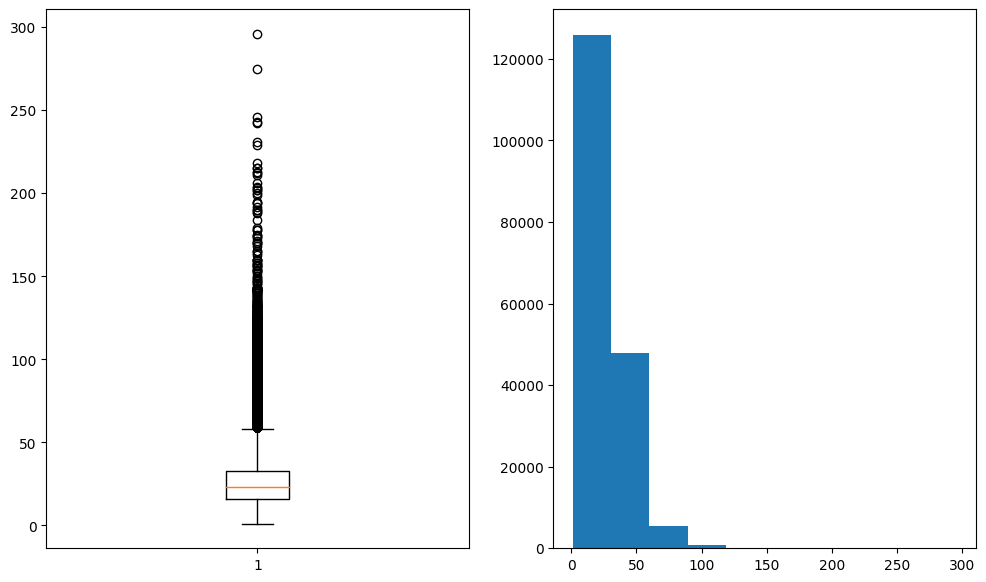

In [32]:
# Check the distribution:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(12,7))
axes[0].boxplot(length_sentence_list)
axes[1].hist(length_sentence_list);

In [33]:
import numpy as np

print(f"95th Percentile: {np.percentile(length_sentence_list,95)}")
print(f"Maximum lenghth: {max(length_sentence_list)}")

95th Percentile: 55.0
Maximum lenghth: 296


In [34]:
# Create the Text Vectorizor:

import tensorflow as tf
from tensorflow.keras import layers

max_token = 68000 # Given in the "Neural Networks for Joint Sentence Classification  in Medical Paper Abstracts" paper.
text_vectorizor = layers.TextVectorization(max_tokens = max_token,
                                           output_sequence_length = 55)

In [35]:
text_vectorizor.adapt(train_abstract_list)
vocab = text_vectorizor.get_vocabulary()

In [36]:
print(f"Length of Vocab: {len(vocab)}")
print(f"Top five words: {vocab[:5]}")
print(f" Bottom five words: {vocab[-5:]}")

Length of Vocab: 64841
Top five words: ['', '[UNK]', 'the', 'and', 'of']
 Bottom five words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# Creating the embedding Layer:
embeddings = layers.Embedding(input_dim=len(vocab),
                              output_dim=128,
                              mask_zero=True)

In [38]:
# Lets check our Vectorizor and the Embeddings:
import random

random_sentence = random.choice(train_abstract_list)
random_vectorization = text_vectorizor([random_sentence])
print(f"Random sentence:\n{random_sentence}\nLength: {len(random_sentence.split(' '))}")

print(f"\nVectorizor Version:\n{random_vectorization}\nVectorizor length: {random_vectorization.shape[1]}")

random_sentence_embedding = embeddings(random_vectorization)
print(f"\nEmbeddings:\n{random_sentence_embedding}\n Embedding shape: {random_sentence_embedding.shape}")

Random sentence:
Preoperative vs. postoperative functional parameters showed significant improvement in both groups .
Length: 12

Vectorizor Version:
[[707  44 163 304 315 147  37 194   5  54  24   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
Vectorizor length: 55

Embeddings:
[[[-0.00060261 -0.04771471  0.03048451 ...  0.02256563 -0.03034929
   -0.01151569]
  [-0.02232763  0.01568426  0.0137363  ...  0.04967691  0.04738582
   -0.03997986]
  [-0.04646827  0.04632189  0.02474863 ...  0.01218315  0.02400743
   -0.02627517]
  ...
  [-0.03684323 -0.02464806  0.03888026 ... -0.03794426  0.0418264
    0.00245055]
  [-0.03684323 -0.02464806  0.03888026 ... -0.03794426  0.0418264
    0.00245055]
  [-0.03684323 -0.02464806  0.03888026 ... -0.03794426  0.0418264
    0.00245055]]]
 Embedding shape: (1, 55, 128)


In [39]:
# But we are going to use universsal sentence Encoder from Tensorflow HUB:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [40]:
# Test our prtrained Embedding on random Sentence:
random_sentence = random.choice(train_abstract_list)
pretrained_embeddings = tf_hub_embedding_layer([random_sentence])
print(f'random_sentence:\n\n{random_sentence}')
pretrained_embeddings

random_sentence:

@ patients reported diverse sensations connected to the anaesthesia ( Group A - @ patients , B - @ patients , C - @ patients , D - @ patients ) .


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-5.20298332e-02,  4.64633256e-02, -3.52638215e-02,
         8.83493666e-03,  5.77913858e-02, -2.19899379e-02,
         2.11781245e-02,  4.49592657e-02, -7.16063157e-02,
        -4.65964824e-02,  7.40360096e-02, -5.65511845e-02,
         5.62375337e-02,  6.55947626e-02,  9.01994016e-03,
         2.93668285e-02, -7.40384161e-02, -6.21278360e-02,
        -7.38040432e-02,  3.94019634e-02, -4.72569838e-02,
         2.27045901e-02,  6.00265861e-02, -5.13840206e-02,
        -4.89344485e-02, -1.89132616e-02, -5.14731258e-02,
        -3.91773740e-03,  7.19606653e-02, -5.46546243e-02,
        -4.09007678e-03,  7.40384758e-02, -4.11186889e-02,
        -2.86386218e-02, -1.07268663e-03, -5.40375598e-02,
         1.31734200e-02,  1.05199525e-02, -5.06053418e-02,
        -7.13491961e-02, -5.69891883e-03,  3.46174650e-03,
         3.05620283e-02, -1.19169103e-02,  3.39007303e-02,
         7.37061575e-02,  2.96567492e-02,  4.52852361e-02,
      

## Preparing the Dataset for Character Level Embeddings:




In [41]:
# convert the sentence to the character level:
char_level_train_sentences = list(map(lambda z:" ".join(list(z)),train_abstract_list))
char_level_test_sentences = list(map(lambda z:" ".join(list(z)),test_abstract_list))
char_level_dev_sentences = list(map(lambda z:" ".join(list(z)),dev_abstract_list))

In [42]:
# Take look:
char_level_train_sentences[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [43]:
count_char_list = [len(char.split(" ")) for char in char_level_train_sentences]
average_length = sum(count_char_list)/len(count_char_list)
average_length

174.70452677182848

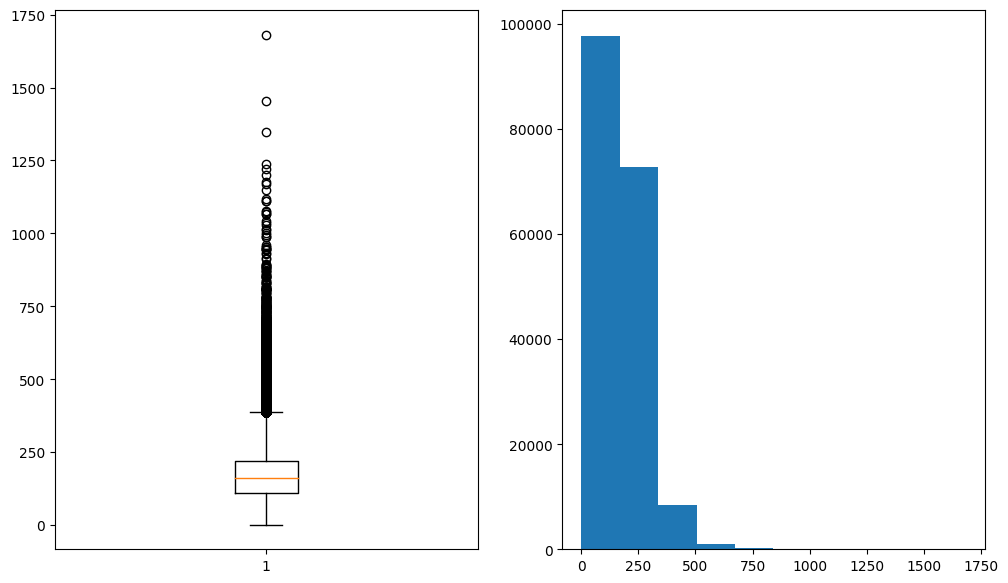

In [44]:
# Plot the Distribution:
fig, axes = plt.subplots(1,2,figsize=(12,7))
axes[0].boxplot(count_char_list)
axes[1].hist(count_char_list);

In [45]:
# Check the 95 percentile:
print(f"95 Percentile: {np.percentile(count_char_list,95)}")
print(f"Max length: {max(count_char_list)}")

95 Percentile: 342.0
Max length: 1681


In [46]:
import string

# Create a list of all possible keyboard characters
keyboard_characters = list(string.ascii_lowercase + string.digits + string.punctuation + " ")
print("".join(keyboard_characters))
print(f"Total length: {len(keyboard_characters)}")

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
Total length: 69


In [47]:
# Setting the max vocab size:
max_size_vocab = 350

# create the Vectorizor layer:
char_vectorizor = layers.TextVectorization(max_tokens = 70,
                                           standardize='lower',
                                           output_sequence_length =max_size_vocab )
char_vectorizor.adapt(char_level_train_sentences)

In [48]:
char_vocab = char_vectorizor.get_vocabulary()
len(char_vocab)

57

In [49]:
# Create the layer for the Feature Embeddings:
char_embeddings = layers.Embedding(input_dim=len(char_vocab),
                                   output_dim = 25, # Given in the Paper
                                   mask_zero=True)

In [50]:
# Check the data on the random sentences:
random_sentence = random.choice(char_level_train_sentences)
print(f"Random sentence: \n{random_sentence}")
print(f"\nSentence character length: {len(random_sentence.split())}")
print(f"\nVectorize Version:\n{char_vectorizor([random_sentence])}\n\nVectorizor length: {len(char_vectorizor([random_sentence]))}")
print(f"\nEmbeddings:\n{char_embeddings(char_vectorizor([random_sentence]))}\n Embeddings shape: {char_embeddings(char_vectorizor([random_sentence])).shape} ")

Random sentence: 
S i m i l a r   r e s u l t s   w e r e   f o u n d   w i t h   t h e   n o n s p e c i f i c   a g o n i s t   t h r o m b i n   r e c e p t o r - a c t i v a t e d   p e p t i d e   (   r e l a t i v e   i n c r e a s e s   o f   @   %   f o r   m a x i m a l   p l a t e l e t   a g g r e g a t i o n   ,   p   =   @   ,   a n d   @   %   f o r   r e s i d u a l   p l a t e l e t   a g g r e g a t i o n   ,   p   =   @   )   b u t   n o t   w i t h   c o l l a g e n   o r   a r a c h i d o n i c   a c i d   a g o n i s t s   .

Sentence character length: 221

Vectorize Version:
[[ 9  4 15  4 12  5  8  8  2  9 16 12  3  9 21  2  8  2 17  7 16  6 10 21
   4  3 13  3 13  2  6  7  6  9 14  2 11  4 17  4 11  5 18  7  6  4  9  3
   3 13  8  7 15 23  4  6  8  2 11  2 14  3  7  8 26  5 11  3  4 22  5  3
   2 10 14  2 14  3  4 10  2 28  8  2 12  5  3  4 22  2  4  6 11  8  2  5
   9  2  9  7 17 19 31 17  7  8 15  5 30  4 15  5 12 14 12  5  3  2 12  2
   3  5 18 18  8  2 18  5 

In [51]:
# Create the model step by step:

# 1. Model for Token Embedding:
token_input = layers.Input(shape = [],dtype=tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_input)
token_output = layers.Dense(300,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_input,
                             outputs = token_output)

# 2.Model for char embedding:
char_input = layers.Input(shape=(1,), dtype=tf.string, name = 'char_input')
char_vector = char_vectorizor(char_input)
char_embedding = char_embeddings(char_vector)
char_bi_dir_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedding)
char_model = tf.keras.Model(inputs = char_input,
                            outputs = char_bi_dir_lstm)

# Concatenate the both embeddings and add a dropout regularization:
token_char_concatenate = layers.Concatenate(name='concatenate')([token_model.output,char_model.output])
reshape_layer = layers.Reshape((35,10))(token_char_concatenate)
regularization_1 = layers.Dropout(0.5)(reshape_layer)

# Create a another Bidirectional LSTM:
bi_dir_lstm = layers.Bidirectional(layers.LSTM(100))(regularization_1)
dense_layer = layers.Dense(64,activation='relu')(bi_dir_lstm)
regularization_2 = layers.Dropout(0.5)(dense_layer)
output_layer = layers.Dense(5,activation='softmax')(regularization_2)

model_1 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="paper_model_without_label_encoding")
model_1.summary()

Model: "paper_model_without_label_encoding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 350)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978

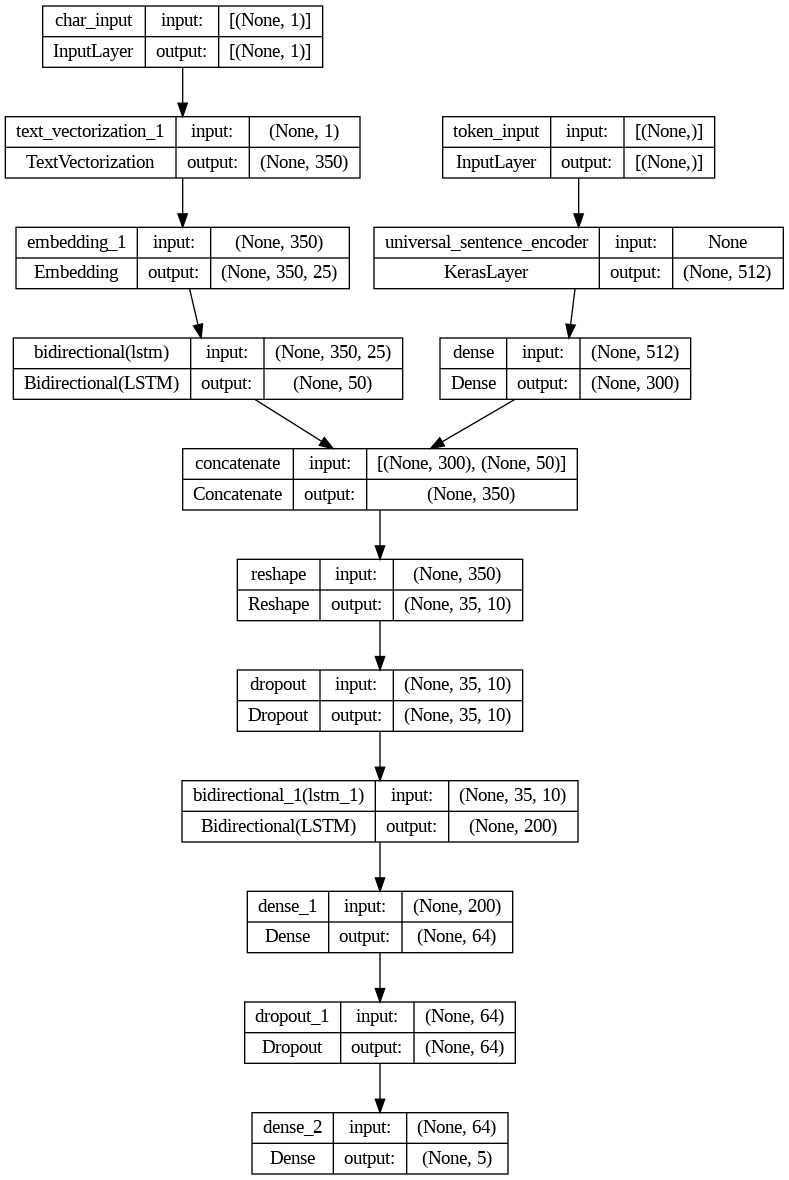

In [52]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_1,show_shapes=True)

In [53]:
# Preprocess the data using tensorflow api:
# Train data:
model_1_train_data = tf.data.Dataset.from_tensor_slices((train_abstract_list,char_level_train_sentences))
model_1_train_labels = tf.data.Dataset.from_tensor_slices((train_target_one_hot))
train_data = tf.data.Dataset.zip(model_1_train_data,model_1_train_labels).batch(32).prefetch(tf.data.AUTOTUNE)

# Test data:
model_1_test_data = tf.data.Dataset.from_tensor_slices((test_abstract_list,char_level_test_sentences))
model_1_test_labels = tf.data.Dataset.from_tensor_slices((test_target_one_hot))
test_data = tf.data.Dataset.zip(model_1_test_data,model_1_test_labels).batch(32).prefetch(tf.data.AUTOTUNE)

# Dev data:
model_1_dev_data = tf.data.Dataset.from_tensor_slices((dev_abstract_list,char_level_dev_sentences))
model_1_dev_labels = tf.data.Dataset.from_tensor_slices((dev_target_one_hot))
dev_data = tf.data.Dataset.zip(model_1_dev_data,model_1_dev_labels).batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
# Compile the model:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [55]:
# Fit the model:
model_1_history = model_1.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=3,
                              validation_data=dev_data,
                              validation_steps=int(0.5 * len(dev_data)))

Epoch 1/3
5627/5627 [==============================] - 275s 46ms/step - loss: 0.8199 - accuracy: 0.6856 - val_loss: 0.6782 - val_accuracy: 0.7460
Epoch 2/3
5627/5627 [==============================] - 252s 45ms/step - loss: 0.6982 - accuracy: 0.7434 - val_loss: 0.6362 - val_accuracy: 0.7609
Epoch 3/3
5627/5627 [==============================] - 248s 44ms/step - loss: 0.6641 - accuracy: 0.7561 - val_loss: 0.6307 - val_accuracy: 0.7643


In [56]:
model_1_predictions = model_1.predict(dev_data).argmax(axis=-1)
model_1_predictions[:5]

942/942 [==============================] - 25s 23ms/step


array([4, 2, 2, 2, 4])

In [57]:
# Generate the scores:
model_1_scores = calculate_results(y_true = dev_target_label_encode,
                               y_pred = model_1_predictions)
model_1_scores

{'accuracy': 76.71146507383442,
 'precision': 0.7638979450055032,
 'recall': 0.7671146507383442,
 'f1': 0.7605939452798027}

# Model_2: Model in Paper with label Encoding



## Convert the line_number and total_lines into oneHotEncode as described in the paper

In [58]:
train_sample_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [59]:
train_sample_df.line_number.value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

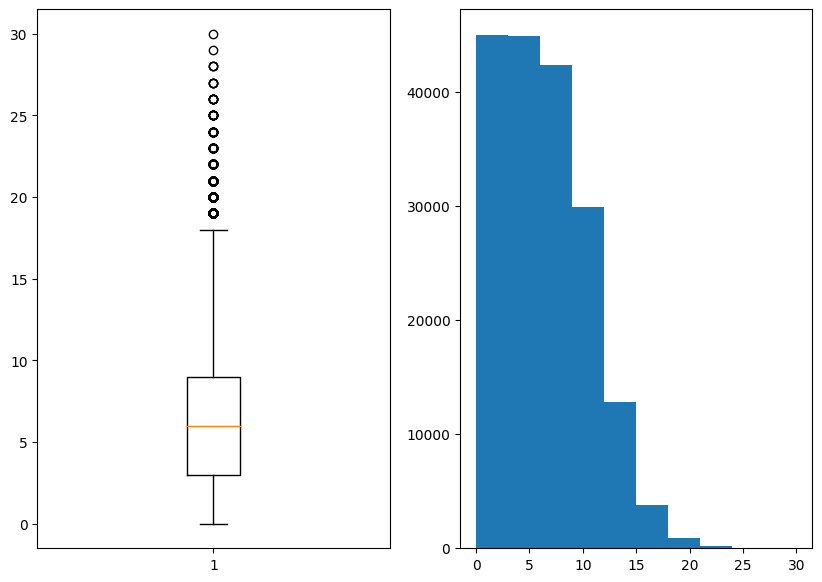

In [60]:
fig,axes=plt.subplots(1,2,figsize=(10,7))
axes[0].boxplot(train_sample_df.line_number)
axes[1].hist(train_sample_df.line_number);

In [61]:
np.percentile(train_sample_df.line_number,98)

15.0

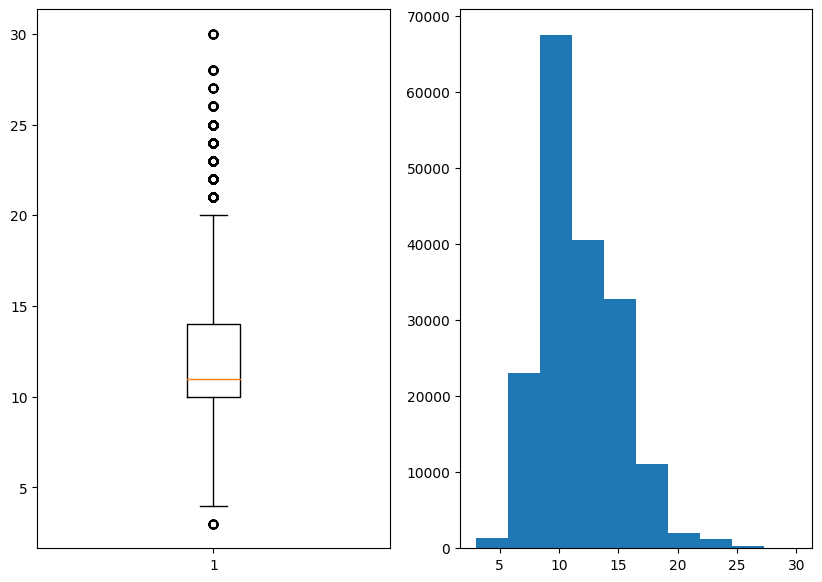

In [62]:
fig,axes=plt.subplots(1,2,figsize=(10,7))
axes[0].boxplot(train_sample_df.total_lines)
axes[1].hist(train_sample_df.total_lines);

In [63]:
np.percentile(train_sample_df.total_lines,98)

20.0

In [64]:
# Create the one_hot_encoder for line_number:
train_line_number_onehot = tf.one_hot(train_sample_df.line_number,depth=15)
test_line_number_onehot = tf.one_hot(test_sample_df.line_number,depth=15)
dev_line_number_onehot = tf.one_hot(dev_sample_df.line_number,depth=15)

In [65]:
# Create the one_hot_encoder for total_lines:
train_line_total_onehot = tf.one_hot(train_sample_df.total_lines,depth=20)
test_line_total_onehot = tf.one_hot(test_sample_df.total_lines,depth=20)
dev_line_total_onehot = tf.one_hot(dev_sample_df.total_lines,depth=20)

In [66]:
# 1. Model for Token Embedding:
token_input = layers.Input(shape = [],dtype=tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_input)
token_output = layers.Dense(300,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_input,
                             outputs = token_output)

# 2.Model for char embedding:
char_input = layers.Input(shape=(1,), dtype=tf.string, name = 'char_input')
char_vector = char_vectorizor(char_input)
char_embedding = char_embeddings(char_vector)
char_bi_dir_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedding)
regularization = layers.Dropout(0.5)(char_bi_dir_lstm )
char_model = tf.keras.Model(inputs = char_input,
                            outputs = regularization)
# Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model= tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Concatenate the both embeddings and add a dropout regularization:
token_char_concatenate = layers.Concatenate(name='concatenate')([token_model.output,char_model.output,line_number_model.output,total_line_model.output])
dense_layer = layers.Dense(320,activation='relu',name='dense_layer')(token_char_concatenate)
reshape_layer = layers.Reshape((32,10))(dense_layer)


# Create a another Bidirectional LSTM:
bi_dir_lstm = layers.Bidirectional(layers.LSTM(100))(reshape_layer)
dense_layer_2 = layers.Dense(64,activation='relu')(bi_dir_lstm)
regularization_2 = layers.Dropout(0.5)(dense_layer_2)
output_layer = layers.Dense(5,activation='softmax')(bi_dir_lstm)
model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input,line_number_model.input,total_line_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_2.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 350)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 350, 25)              1425    

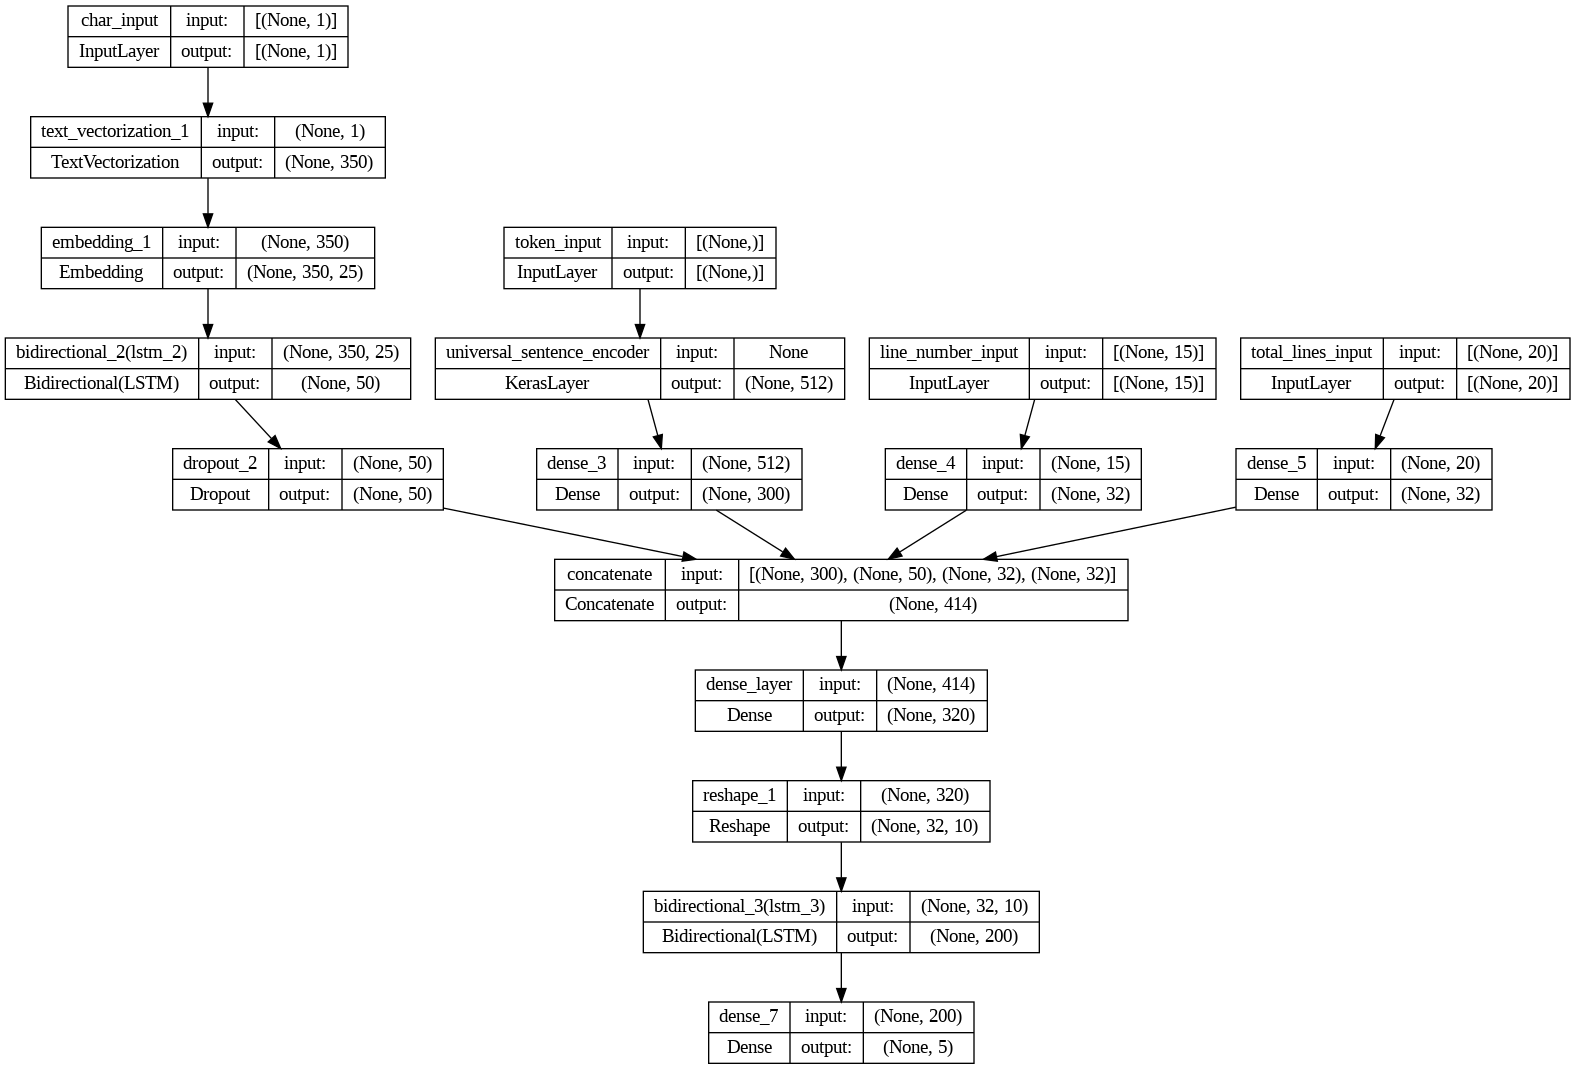

In [67]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_2,show_shapes=True)

In [68]:
# Train data:
model_2_train_data = tf.data.Dataset.from_tensor_slices((train_abstract_list,char_level_train_sentences,train_line_number_onehot,train_line_total_onehot))
model_2_train_labels = tf.data.Dataset.from_tensor_slices((train_target_one_hot))
train_data = tf.data.Dataset.zip(model_2_train_data,model_2_train_labels).batch(32).prefetch(tf.data.AUTOTUNE)

# Test data:
model_2_test_data = tf.data.Dataset.from_tensor_slices((test_abstract_list,char_level_test_sentences,test_line_number_onehot,test_line_total_onehot))
model_2_test_labels = tf.data.Dataset.from_tensor_slices((test_target_one_hot))
test_data = tf.data.Dataset.zip(model_2_test_data,model_2_test_labels).batch(32).prefetch(tf.data.AUTOTUNE)

# Dev data:
model_2_dev_data = tf.data.Dataset.from_tensor_slices((dev_abstract_list,char_level_dev_sentences,dev_line_number_onehot,dev_line_total_onehot))
model_2_dev_labels = tf.data.Dataset.from_tensor_slices((dev_target_one_hot))
dev_data = tf.data.Dataset.zip(model_2_dev_data,model_2_dev_labels).batch(32).prefetch(tf.data.AUTOTUNE)

In [69]:
# Compile the model:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [70]:
model_2_history = model_2.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=3,
                              validation_data=dev_data,
                              validation_steps=int(0.5 * len(dev_data)))

Epoch 1/3
5627/5627 [==============================] - 269s 45ms/step - loss: 0.4121 - accuracy: 0.8397 - val_loss: 0.3548 - val_accuracy: 0.8645
Epoch 2/3
5627/5627 [==============================] - 248s 44ms/step - loss: 0.3271 - accuracy: 0.8760 - val_loss: 0.3413 - val_accuracy: 0.8695
Epoch 3/3
5627/5627 [==============================] - 263s 47ms/step - loss: 0.2960 - accuracy: 0.8889 - val_loss: 0.3429 - val_accuracy: 0.8702


In [71]:
model_2_prediction = model_2.predict(dev_data).argmax(axis=-1)

942/942 [==============================] - 24s 22ms/step


In [72]:
val_scores_model_2 = calculate_results(y_true = dev_target_label_encode,
                               y_pred = model_2_prediction)
val_scores_model_2

{'accuracy': 87.42326198772193,
 'precision': 0.8743793597936238,
 'recall': 0.8742326198772192,
 'f1': 0.8714549314167612}

## Now check the model on the Test data:

In [73]:
test_sample_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9
1,BACKGROUND,It is not clear whether these patients would b...,1,9
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9
4,METHODS,Primary outcomes were improvement in quality o...,4,9


In [74]:
test_predictions_prob = model_2.predict(test_data)
test_predictions_label = test_predictions_prob.argmax(axis=-1)
test_predictions_label

945/945 [==============================] - 21s 22ms/step


array([0, 0, 3, ..., 4, 1, 1])

In [75]:
# calculate the score:
test_scores_model_2 = calculate_results(y_true = test_target_label_encode,
                               y_pred = test_predictions_label)
test_scores_model_2

{'accuracy': 87.98821660267443,
 'precision': 0.8807974775906164,
 'recall': 0.8798821660267443,
 'f1': 0.8769609758776244}

In [76]:
test_prediction = [label_encoder_classes[i] for i in test_predictions_label]
test_prediction[:5]

['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'METHODS']

In [77]:
# Make the prediction column to the test dataset:
test_sample_df['model_predictions'] = test_prediction

In [78]:
test_sample_df.head()

,target,text,line_number,total_lines,model_predictions
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9,BACKGROUND
1,BACKGROUND,It is not clear whether these patients would b...,1,9,BACKGROUND
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9,OBJECTIVE
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9,METHODS
4,METHODS,Primary outcomes were improvement in quality o...,4,9,METHODS


In [79]:
# Check the columns with wrong predictions:
wrong_predictions = test_sample_df.loc[test_sample_df.target != test_sample_df.model_predictions,:]
wrong_predictions

,target,text,line_number,total_lines,model_predictions
13,OBJECTIVE,The present pilot study tested the hypothesis ...,3,10,BACKGROUND
18,RESULTS,Naltrexone and alprazolam each significantly a...,8,10,CONCLUSIONS
24,OBJECTIVE,We tested the impact of conceptual instruction...,3,10,BACKGROUND
25,OBJECTIVE,We also examined the learning processes suppor...,4,10,BACKGROUND
26,METHODS,We worked with @ second - and third-grade chil...,5,10,RESULTS
...,...,...,...,...,...
30153,BACKGROUND,"Various laboratory examinations , multi-detect...",5,10,METHODS
30159,BACKGROUND,Comparison of state-designated primary and com...,0,12,OBJECTIVE
30178,RESULTS,Factors positively associated with DAPT use we...,6,13,METHODS
30184,CONCLUSIONS,Several correlates of DAPT were identified .,12,13,RESULTS


In [80]:
test_sample_df.shape

(30212, 5)

In [81]:
# Make predictions on the custom abstract:
samples_abstract = [{"abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.", "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/", "details": "RCT of a manualized social treatment for high-functioning autism spectrum disorders"}, {"abstract": "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.", "source": "https://pubmed.ncbi.nlm.nih.gov/28012571/", "details": "Formatting removed (can be used to compare model to actual example)"}, {"abstract": "Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.", "source": "https://pubmed.ncbi.nlm.nih.gov/28942748/", "details": "Effect of nutrition on mental health"}, {"abstract": "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.", "source": "https://pubmed.ncbi.nlm.nih.gov/22244707/", "details": "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"}]


In [82]:
samples_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [83]:
samples_abstract[0]

{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
 'details': 'RCT of a manualized 

In [84]:
# Create a function to pre-process the text data:
def preprocess_test(example_dict):
  # Split the line by the ".":
  sentence_list = example_dict['abstract'].split(".")[:-1]

  # Get the char level sentences:
  char_level = list(map(lambda z: " ".join(list(z)),sentence_list))

  # Generate the line no:
  line_number = range(len(sentence_list))

  # Line no starts from zero , so we have to subtract it by 1
  total_length =  len(sentence_list) -1

  # Generate the list of total lines:
  total_lines = [total_length ] * (total_length + 1)

  # Create the Data Frame:
  dataframe = pd.DataFrame({"sentence":sentence_list,"character":char_level,'line_number':line_number,'total_lines':total_lines})

  # Generate the one hot encode for line number and total lines:
  line_number_one_hot = tf.one_hot(dataframe.line_number, depth=15)
  total_line_one_hot = tf.one_hot(dataframe.total_lines, depth=20)

  return dataframe,line_number_one_hot,total_line_one_hot

In [85]:
# Create a function to plot results:
def plot_predictions(abstract,model):
  for count,sub_abstract in enumerate(abstract):
    dataframe,line_number_one_hot,total_line_one_hot  =  preprocess_test(sub_abstract)

    trial_data = tf.data.Dataset.from_tensor_slices((dataframe.sentence.to_list(), dataframe.character.to_list(), line_number_one_hot, total_line_one_hot))
    custom_dataset_blank = tf.data.Dataset.from_tensor_slices(np.zeros(shape=(dataframe.shape[0],5)))
    custom_dataset = tf.data.Dataset.zip((trial_data, custom_dataset_blank)).batch(1)
    predictions = model.predict(custom_dataset).argmax(axis=-1)
    actual_labels = [label_encoder_classes[i] for i in predictions]

    # Now print the Results:

    print(f"\nModel prediction: {count} ______________\n")
    for z in range(dataframe.shape[0]):
      print(f"{actual_labels[z]}: {dataframe.sentence.to_list()[z]}" )

In [86]:
plot_predictions(samples_abstract,model_2)

8/8 [==============================] - 0s 14ms/step

Model prediction: 0 ______________

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs
METHODS:  Participants were randomly assigned to treatment or wait-list conditions
METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language
METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition
RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)
METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents
RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity
RESULTS:  Standardized effect size estimates were primarily in the